# Analyzing Data and Interpreting Images with OpenAI's o1 Reasoning Model vs. GPT

## Introduction
OpenAI's o1 reasoning model is designed for complex problem-solving, data analysis, and image interpretation by simulating a multi-step thought process before generating responses. Unlike traditional GPT models, which produce output in a single pass, reasoning models use internal **reasoning tokens** to explore multiple approaches before finalizing an answer.
<p align="center">
    <img src="https://cdn.openai.com/API/images/guides/reasoning_tokens.png" alt="Reasoning Tokens" width="600">
</p>  

*Source: [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning)*

**Key Differences: o1 Reasoning Model vs. GPT**
- Multi-step reasoning: o1 evaluates different solutions before selecting the best response.
- Deeper analytical capabilities: Optimized for complex data interpretation tasks.
- Context-aware image analysis: Provides more structured and insightful image descriptions.
- Reasoning Effort Control: Users can adjust the depth of reasoning (`low`, `medium`, `high`).


For more details, refer to the [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning).


## Purchase and Store API Key

You need to **purchase** your [OpenAI](https://openai.com/) API key and store it securely, such as in **AWS Secrets Manager**.

- **Key Name:** `api_key`  
- **Key Value:** `<your OpenAI API key>`  
- **Secret Name:** `openai`  

## Install Python Libraries

- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.

In [1]:
pip install openai -q

Note: you may need to restart the kernel to use updated packages.


## Import Required Libraries

The following libraries are used in this notebook:

- **boto3**: AWS SDK for Python, used to interact with AWS services.
- **json**: Standard Python library for handling JSON data.
- **IPython.display**: Provides tools to display images, Markdown content, and other rich media in Jupyter Notebook.
- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.
- **pandas**: A powerful library for data manipulation and analysis.
- **pprint**: Pretty prints data structures for better readability.

In [2]:
import boto3
import json
from IPython.display import display, Image, Markdown
from openai import OpenAI
import pandas as pd
from pprint import pprint

## Retrieve API Keys Securely from AWS Secrets Manager

The following function, `get_secret()`, retrieves a secret from **AWS Secrets Manager**. This is a secure way to store and access sensitive credentials, such as API keys, without hardcoding them into the script

In [3]:
def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

## Initialize OpenAI Client

The following code initializes the OpenAI client using a securely stored API key retrieved from AWS Secrets Manager.

In [4]:
client = OpenAI(api_key= get_secret('openai')['api_key'])

## Load and Analyze the Diamonds Dataset

This notebook uses the **diamonds dataset ([diamonds.csv](https://github.com/lbsocial/data-analysis-with-generative-ai/blob/main/diamonds.csv))**, which contains detailed attributes of diamonds, including weight, color, clarity, and price.

One interesting pattern in the dataset is that **diamonds with "IF" (Internally Flawless) clarity tend to have the lowest average price** compared to other clarity grades. This observation is counterintuitive, as one might expect the highest-clarity diamonds to be the most expensive.

In [13]:
df = pd.read_csv('Flight_data.csv')
data_json = df.to_json(orient="records")
df.head()

,FL_DATE,DEP_DELAY,ARR_DELAY,AIR_TIME,DISTANCE,DEP_TIME,ARR_TIME
0,1/1/2006,5,19,350,2475,9.083333,12.483334
1,1/2/2006,167,216,343,2475,11.783334,15.766666
2,1/3/2006,-7,-2,344,2475,8.883333,12.133333
3,1/4/2006,-5,-13,331,2475,8.916667,11.950000
4,1/5/2006,-3,-17,321,2475,8.950000,11.883333


## Generate Data Analysis Prompt for OpenAI Model

To investigate why diamonds with **IF (Internally Flawless) clarity** have the **lowest average price**, we generate a structured prompt for the OpenAI model. The model will analyze the dataset and generate insights, including **Python code for visualizations**.


In [14]:
data_prompt = f"Analyze the provided data and determine why AIR_TIME does not correlate with DISTANCE. Data: {data_json}"
# print(prompt)

## Define a Function to Get Assistance from OpenAI GPT-4o

The following function, `openai_gpt_help()`, sends a prompt to OpenAI's **GPT-4o model** and returns a response. It also prints the number of tokens used in the request.

In [15]:
def openai_gpt_help(prompt):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=messages,
        temperature = 0
    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [16]:
gpt_result = openai_gpt_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=410, prompt_tokens=32428, '
 'total_tokens=32838, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [17]:
display(Markdown(gpt_result))

The data provided shows flight information, including departure and arrival delays, air time, and distance for various flights. The key observation here is that the `AIR_TIME` does not correlate with `DISTANCE`. This lack of correlation can be attributed to several factors:

1. **Consistent Distance**: The data shows that the `DISTANCE` for most flights is the same or very similar, with values like 2475, 2586, 2611, etc. This consistency in distance means that any variation in `AIR_TIME` is not due to changes in distance but rather other factors.

2. **Variability in Air Time**: The `AIR_TIME` varies significantly even for flights with the same `DISTANCE`. This suggests that factors other than distance are influencing the air time.

3. **Operational Factors**: Several operational factors can affect air time, including:
   - **Weather Conditions**: Adverse weather can lead to longer air times due to rerouting or holding patterns.
   - **Air Traffic Control**: Congestion in airspace or at airports can lead to delays and increased air time.
   - **Flight Path Variations**: Different flight paths due to air traffic control instructions or weather can result in different air times for the same distance.
   - **Aircraft Performance**: Different aircraft types or variations in aircraft performance can also affect air time.

4. **Departure and Arrival Delays**: The data includes `DEP_DELAY` and `ARR_DELAY`, which indicate that flights often experience delays. These delays can affect the total time a flight takes, but they do not necessarily correlate with the distance traveled.

5. **Time of Day and Scheduling**: Flights scheduled at different times of the day may experience different air times due to varying levels of air traffic and airport congestion.

In summary, the lack of correlation between `AIR_TIME` and `DISTANCE` in the data is primarily due to the consistent distances and the influence of various operational factors that affect air time independently of the distance traveled.

## Define a Function to Get Assistance from OpenAI o1 Model  

The following function, `openai_o_help()`, sends a prompt to OpenAI's **o1 reasoning model** and returns a response.  

### Key Differences Between o1 and GPT Models:
- **Reasoning Effort**: The o1 model allows users to control reasoning depth using `reasoning_effort` (`low`, `medium`, `high`).  
- **No Temperature Parameter**: Unlike GPT models, **o1 does not support `temperature`**.  
- **Developer Messages Replace System Messages**:  
  - Starting with `o1-2024-12-17`, **developer messages** replace **system messages** to align with chain-of-command behavior.  

### Best Practices for Prompting o1  
- **Keep prompts simple and direct.**  
- **Avoid chain-of-thought prompts.** o1 reasons internally, so step-by-step instructions aren't needed.  
- **Use delimiters for clarity.** Use Markdown, XML tags, or section titles.  
- **Try zero-shot first.** If needed, add few-shot examples that closely match your goal.  
- **Be explicit.** Clearly define success criteria and constraints.  
- **Markdown is disabled by default.** To enable, start with `"Formatting re-enabled"`.  

Source: [OpenAI Reasoning Models Best Practices Guide](https://platform.openai.com/docs/guides/reasoning-best-practices).  


In [18]:
def openai_o_help(prompt):
    messages = [ {"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='o1',
        reasoning_effort="high", # low, medium or high
        messages=messages,

    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [19]:
o1_result = openai_o_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=1828, prompt_tokens=32427, '
 'total_tokens=34255, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=1600, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [20]:
print(o1_result)

A closer look at the data reveals that multiple flights show the same “as‐the‐crow‐flies” DISTANCE but widely differing AIR_TIME values. In other words, rows with the same DISTANCE can nonetheless have airtimes differing by an hour or more. This disconnect arises because “distance” is only one piece of what determines a flight’s actual flying time. Factors such as prevailing winds (flying eastbound vs. westbound), routing variations, holding patterns, aircraft type, and even schedule padding can all lengthen or shorten the AIR_TIME regardless of the nominal point‐to‐point distance. Consequently, when you lump together flights of the same (or even similar) distances but traveling under different operational conditions, you lose any simple one‐to‐one correlation between DISTANCE and AIR_TIME.


## Load and Display an Image from a URL

This code retrieves an image from a specified URL and displays it using the **PIL (Pillow) library**.

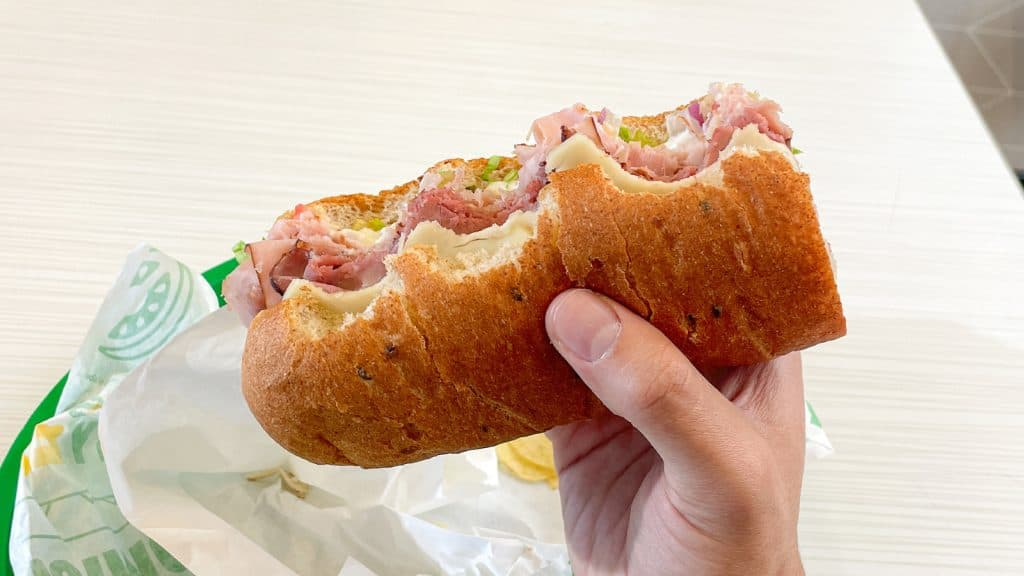

In [25]:
from PIL import Image
import requests
from io import BytesIO

image_url = "https://www.dexerto.com/cdn-cgi/image/width=3840,quality=75,format=auto/https://editors.dexerto.com/wp-content/uploads/2023/11/23/Subway-Sandwich-Eaten-Wrong-1024x576.jpeg"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img.show()

## Create an Image Analysis Prompt

The following code constructs a **structured prompt** for analyzing an image. It sends both **text input** and an **image URL** to an AI model for interpretation.


In [26]:
image_prompt = [
                    {"type": "text", "text": 'what is wrong with this image?'},
                    {"type": "image_url", "image_url": {
                        "url": image_url}
                    }
                ]

In [27]:
gpt_result = openai_gpt_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=32, prompt_tokens=779, '
 'total_tokens=811, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [28]:
display(Markdown(gpt_result))

The image shows a sandwich being held upside down, which might cause the fillings to fall out. This could be considered unusual or incorrect for eating a sandwich.

In [29]:
o1_result = openai_o_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=2538, prompt_tokens=688, '
 'total_tokens=3226, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=2432, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [30]:
display(Markdown(o1_result))

I don’t see any obvious flaw or defect—at a glance, it just looks like a half‐eaten deli sandwich on a branded wrapper. There’s nothing clearly “wrong” in terms of mold, foreign objects, or anything else unusual. If there’s something specific you’re noticing (such as an unexpected ingredient, missing filling, or an off color), it isn’t immediately visible in the photo provided. Could you say more about what you think might be wrong?

## References  
- **OpenAI Reasoning Models Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning)  
- **OpenAI Reasoning Models Best Practices Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning-best-practices)  
- **Colin Jarvis. “Reasoning with O1.” DeepLearning.AI.** Accessed February 14, 2025. [DeepLearning.AI](https://www.deeplearning.ai/short-courses/reasoning-with-o1/)  